In [46]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from argparse import Namespace

from sklearn import metrics
from sklearn.model_selection import train_test_split

from datasetPreProcessing import LoadDatasetByName
from models import *
from methods import *

import functools
import numpy as np
import pandas as pd
import torch
#import os

import pyod

from pyod.models.alad import ALAD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF

from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.loda import LODA

from pyod.models.pca import PCA
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.kpca import KPCA

# distribution based OD
from pyod.models.kde import KDE

from pyod.models.anogan import AnoGAN

#from pyod.models.auto_encoder_torch import AutoEncoder as pyodAE
#from pyod.models.vae import VAE as pyodVAE
#import pyod.models as odm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# import data
#DATASET = 'ECU_IoHT_data'
#DATASET = 'TON_IoT_data'
#DATASET = 'creditcard_data'
DATASET = 'network_data'
"""___________________Hyper Parameters________________________"""
repetitions = 1

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
print(raw_data.shape, anomalous_raw.shape)
# Pre-process data
trim_data = True
normalize_data = True
normalization_scheme = "standard_scaling"
filter_corrcoef = True
remove_noise = False 
noise_threshold = 5
return_dict = {}
SPLIT = [0.9, 0.05, 0.05]
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
print(anomalous_data.shape)
# 
specificity_list, recall_list = [], []
""" X = np.concatenate((raw_data, anomalous_raw), axis=0)
Y = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)
print(X.shape, Y.shape)
# train test split
#X_train, X_test = train_test_split(X, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) """

(13343, 13) (2046, 13)
Untrimmed columns:  [2, 3, 4, 5, 6, 7, 8, 11, 12]
Train data shape after trim:  (12008, 9)
Train data shape after filter corrcoef:  (12008, 5)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (12008, 5)
(2046, 5)


' X = np.concatenate((raw_data, anomalous_raw), axis=0)\nY = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)\nprint(X.shape, Y.shape)\n# train test split\n#X_train, X_test = train_test_split(X, test_size=0.1)\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) '

In [48]:
# list of OD models training on data with both normal data and anomalies
unsupervised_ODs = []
# list of OD models training on data with only normal data
semi_supervised_ODs = [
                        (ALAD(), 'ALAD'), 
                        #
                        (LOF(), 'LOF'),
                        (KNN(), 'KNN'),
                        (CBLOF(), 'CBLOF'),
                        (COF(), 'COF'),
                        #
                        (HBOS(), 'HBOS'),
                        (IForest(), 'IForest'),
                        (DeepSVDD(), 'DSVDD'),
                        #
                        (PCA(), 'PCA'),
                        #(KPCA(), 'KPCA'),
                        #(AnoGAN(), 'AnoGAN'),
                        #(pyodAE(hidden_neurons=(64,8,4,8,64)), 'AutoEncoder'),
                        #(pyodVAE(), 'VAE'),
                    ]
#semi_supervised_ODs = [(AnoGAN(), 'AnoGAN'),]

In [50]:
# pipeline
pr_dict, roc_dict, mcc_dict = {}, {}, {} # dictionaries of all models' performances to plot

X_train, y_train = train_data, np.zeros(train_data.shape[0])
X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)

for clf, clf_name in semi_supervised_ODs: # loop over all algorithms
    # create prediction (probability) list to compute average upon
    pr_list, fpr_tpr_list, MCC_threshold_list = np.array([]), np.array([]), np.array([])
    predictions=[]
    for _ in range(repetitions): # r repetitions
        clf.fit(X=X_train, y=None) # fit
        # test
        y_pred = clf.predict_proba(X_test)[:,-1]
        predictions.append(y_pred)
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    # add metrics to list
    """ pr_list = np.append(pr_list, (precision, recall))
    fpr_tpr_list = np.append(fpr_tpr_list, (fpr, tpr))
    MCC_threshold_list = np.append(MCC_threshold_list, (mcc, thresholds)) """
    # take average of the metrics
    """ precision, recall = pr_list[::2].mean(), pr_list[1::2].mean()
    fpr, tpr = fpr_tpr_list[::2].mean(), fpr_tpr_list[1::2].mean()
    mcc, thresholds = MCC_threshold_list[::2].mean(), MCC_threshold_list[1::2].mean() """
    # add to dicttionary to plot across all classifiers for comparison
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)

# visualize across all classifiers
#visualize_curve(metrics=pr_dict, x_label="Recall", y_label="Precision", title="Precision-Recall Curve") # visualize PR
#visualize_curve(metrics=roc_dict, x_label="False Positive Rate", y_label="True Positive Rate", title="ROC") # visualize ROC
#visualize_curve(metrics=mcc_dict, x_label="Thresholds", y_label="MCC", title="MCC-Threshold Curve") # visualize MCC



/Users/xxd/Documents/Course/MIE696/mie696/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


376/376 [==============================] - 0s 266us/step
Model: "model_8238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_8438 (Dense)          (None, 64)                320       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_14 (TFOpL  (None, 32)                0         
 ambda)                                                          
                                                                 
 tf.math.pow_14 (TFOpLambda  (None, 32)                0         
 )                                                               
                                                                 

In [51]:
# import trained AE model and evaluate
from models import AutoEncoder

if True:
    model = AutoEncoder(num_feature=X_test.shape[-1], latent_dim=4, hidden_dim=64, activation="leaky_relu")
    model.load_state_dict(torch.load('../model/param_AE_'+DATASET))

    # standard for AE is the train average reconstruction loss
    X_temp = torch.tensor(X_train).to(torch.float)
    standard = ((model(X_temp) - X_temp)**2).detach().numpy()
    standard = np.mean(np.sum(standard, axis=-1))

    X_temp = torch.tensor(X_test).to(torch.float)
    y_pred = ((model(X_temp) - X_temp)**2).detach().numpy()
    y_pred = np.sum(y_pred, axis=-1)
    #print(y_pred.shape)
    #y_pred = (y_pred - min(y_pred)) / (max(y_pred) - min(y_pred))
    y_pred = 1 / (1 + np.exp(-y_pred + standard))

    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred)
    fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)

    pr_dict[model.name] = (recall, precision)
    roc_dict[model.name] = (fpr, tpr)
    mcc_dict[model.name] = (thresholds, mcc)


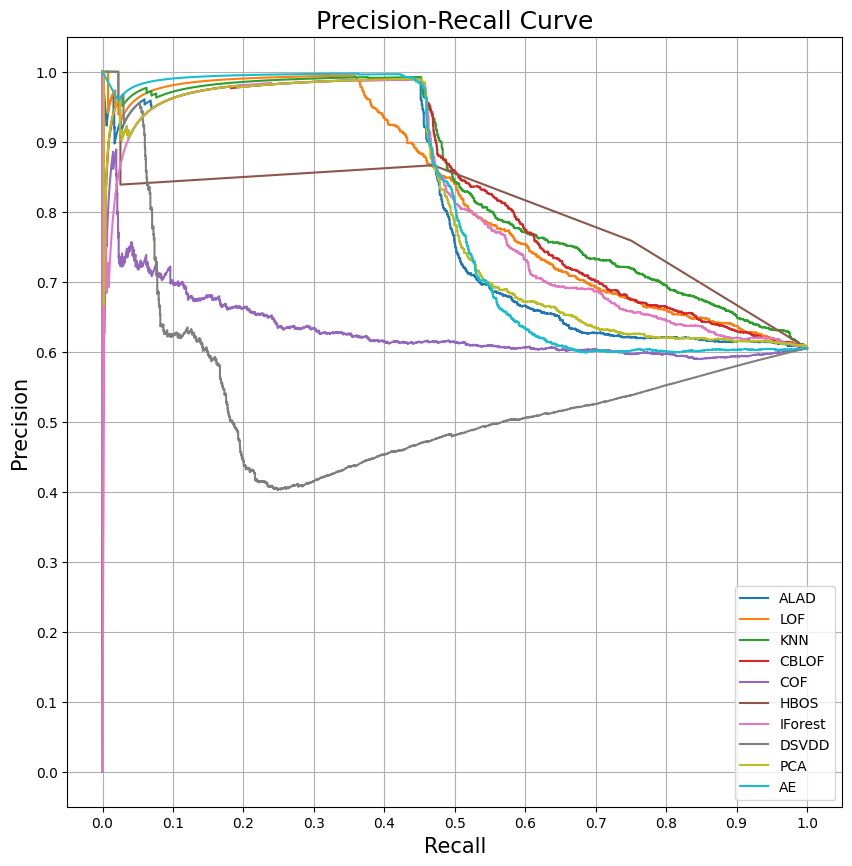

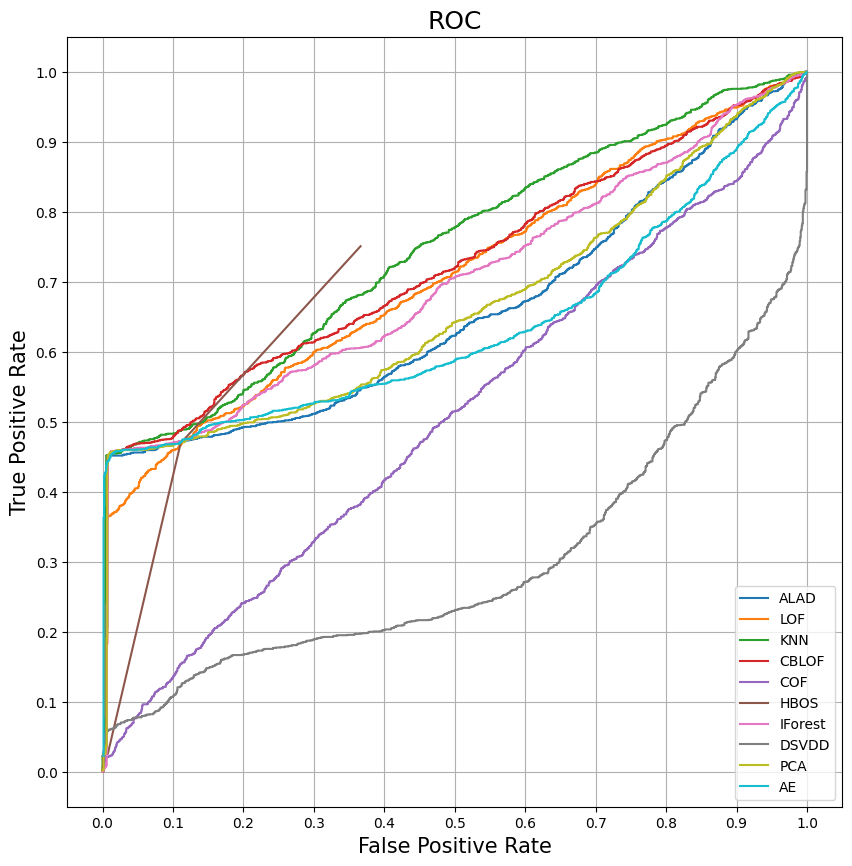

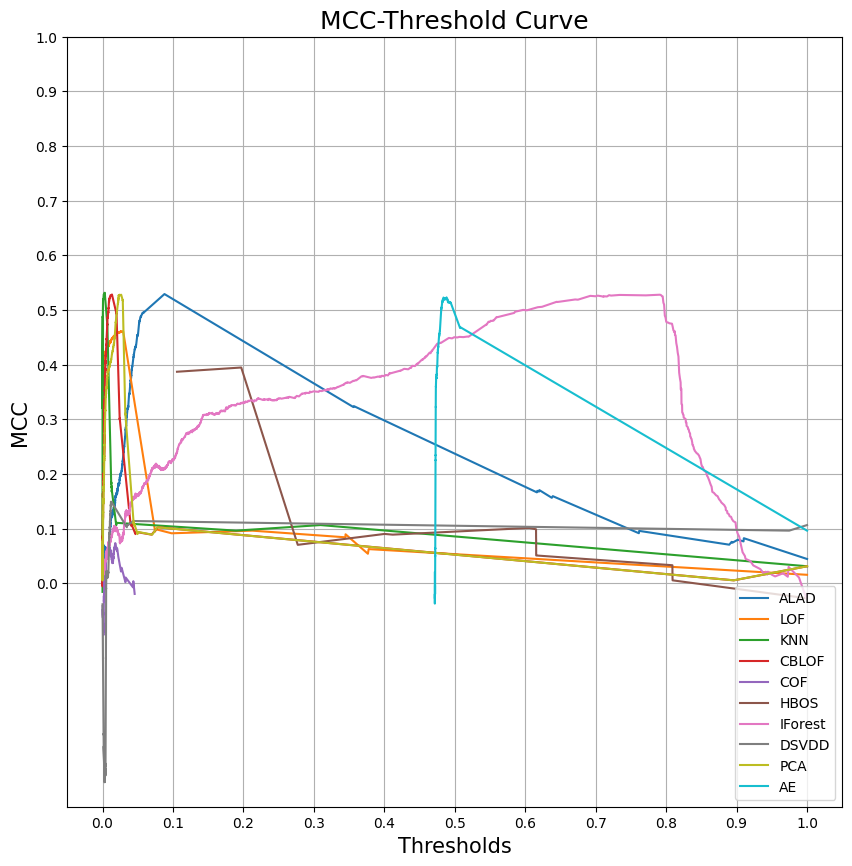

In [52]:
SAVE = False
visualize_curve(metrics=pr_dict, x_label="Recall", y_label="Precision", title="Precision-Recall Curve", save=SAVE) # visualize PR
visualize_curve(metrics=roc_dict, x_label="False Positive Rate", y_label="True Positive Rate", title="ROC", save=SAVE) # visualize ROC
visualize_curve(metrics=mcc_dict, x_label="Thresholds", y_label="MCC", title="MCC-Threshold Curve", save=SAVE) # visualize MCC

In [53]:
print(mcc_dict['PCA'][1])

[0.03128056 0.00550275 0.10259183 ... 0.06766806 0.00523327 0.01935645]


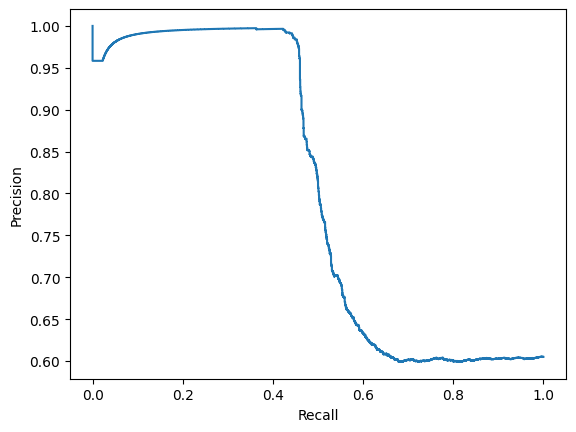

0.8018303436196812
0.6345770133374338


Text(0, 0.5, 'tpr')

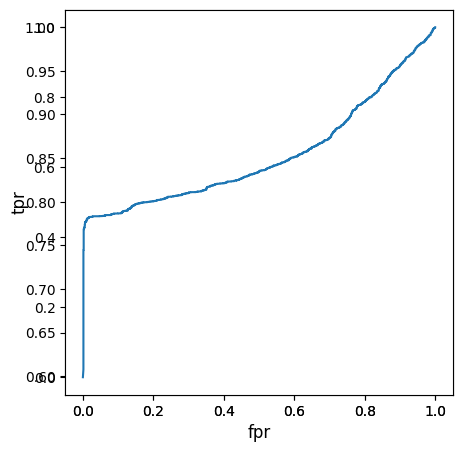

In [54]:
# metrics

precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
fpr, tpr, _ = metrics.roc_curve(y_true=y_test, y_score=y_pred)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()
print(metrics.auc(recall, precision))
print(metrics.auc(fpr, tpr))

fig = plt.figure(figsize = (5, 5))
ax1 = fig.add_subplot(1,1,1) 
ax2 = fig.add_subplot(1,1,1)
ax1.grid()

ax1.plot(recall, precision)
ax2.plot(fpr, tpr)

ax2.set_xlabel('fpr', fontsize = 12)
ax2.set_ylabel('tpr', fontsize = 12)